In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

import sklearn
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

import time

import pickle

import shap

In [2]:
# On supprime les avertissements nous indiquant que l'on change les valeurs de notre jeu de données d'origine
pd.options.mode.chained_assignment = None

## Classification

In [3]:
# On charge nos données
df = pd.read_csv('data_preprocessed.csv')
df.drop(columns=['Unnamed: 0', 'index'], inplace=True)
df.set_index('SK_ID_CURR', inplace=True)

In [4]:
# On sépare en jeu de test et jeu d'entraînement
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]

In [5]:
train_df.shape

(307507, 573)

In [6]:
# On regarde l'équilibre de nos classes
train_df['TARGET'].value_counts()

0.0    282682
1.0     24825
Name: TARGET, dtype: int64

In [7]:
# On prépare nos folds
X = train_df.drop('TARGET', axis = 1)
y = train_df['TARGET']
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=24)
cv = folds.split(X, y)
cv = list(cv)

## Baseline

In [8]:
t0 = time.time()

oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()
feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

# On sépare notre train en train et validation
for n_fold, (train_idx, valid_idx) in enumerate(cv):
    train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
    valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]
    
    clf = XGBClassifier(booster='gblinear', random_state=24, use_label_encoder=False, eval_metric='logloss')
    clf.fit(train_x, train_y)
    
    oof_preds[valid_idx] = clf.predict_proba(valid_x)[:, 1]
    sub_preds += clf.predict_proba(test_df[feats])[:, 1] / folds.n_splits

    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))

t1 = time.time()
time_round = np.round(t1 - t0, 2)
print(f'Time : {time_round} secondes')

Fold  1 AUC : 0.765381
Fold  2 AUC : 0.771034
Fold  3 AUC : 0.766545
Fold  4 AUC : 0.772625
Fold  5 AUC : 0.764677
Time : 103.25 secondes


## Gestion des classes

In [9]:
results = []

In [10]:
scale_class = np.sqrt(df['TARGET'].value_counts()[0] / df['TARGET'].value_counts()[1])

In [11]:
t0 = time.time()

oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()
feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

# On sépare notre train en train et validation
for n_fold, (train_idx, valid_idx) in enumerate(cv):
    train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
    valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]
    
    clf = XGBClassifier(n_estimators=300, booster='gblinear', learning_rate=0.2, random_state=24,
                        scale_pos_weight=scale_class, use_label_encoder=False, eval_metric='logloss')
    clf.fit(train_x, train_y)
    
    oof_preds[valid_idx] = clf.predict_proba(valid_x)[:, 1]
    sub_preds += clf.predict_proba(test_df[feats])[:, 1] / folds.n_splits

    roc_score = roc_auc_score(valid_y, oof_preds[valid_idx])
    results.append(roc_score)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_score))

t1 = time.time()
time_round = np.round(t1 - t0, 2)
print(f'Time : {time_round} secondes')

Fold  1 AUC : 0.766141
Fold  2 AUC : 0.771751
Fold  3 AUC : 0.767247
Fold  4 AUC : 0.773094
Fold  5 AUC : 0.765850
Time : 254.02 secondes


In [12]:
print('Score moyen :', round(np.mean(results), 4))

Score moyen : 0.7688


## RandomizedSearch

In [9]:
model = XGBClassifier(scale_pos_weight=scale_class, random_state=24,
                      use_label_encoder=False, eval_metric='logloss')

params_xgbr = {'learning_rate' : (0.05, 0.10, 0.15, 0.20, 0.25), 'n_estimators' : [100, 250, 400, 500, 600]}

In [10]:
model_cv = RandomizedSearchCV(model, params_xgbr, verbose=1, cv=5, scoring='roc_auc')             

model_cv.fit(X, y)

# Meilleur paramètres du modèle
best_hyperparam = model_cv.best_params_
best_model_cv = model_cv.best_estimator_

#Score moyen des validations croisées du meilleur estimateur
best_score_cv = model_cv.best_score_

print(best_hyperparam, '\n')
print(best_model_cv, '\n')
print(best_score_cv)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'n_estimators': 400, 'learning_rate': 0.05} 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=400, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=24,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=3.374461278849885,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None) 

0.7843409036113077


## Notre modèle

In [13]:
# On utilise le résultat de notre RandomizedSearchCV
clf = XGBClassifier(n_estimators=400, learning_rate=0.05, scale_pos_weight=scale_class,
                    random_state=24, use_label_encoder=False, eval_metric='logloss')
clf.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=400, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=24,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=3.374461278849885,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [14]:
# On enregistre le modèle
filename = 'xgboostclassifier.pkl'
pickle.dump(clf, open(filename, 'wb'))

## Feature importance (Shap explainer)

In [15]:
# On utilise toutes nos données sauf notre cible
val_explainer = df.drop('TARGET', axis = 1)

In [16]:
# On calcule l'explainer de notre modèle
explainer = shap.Explainer(clf, val_explainer)

In [17]:
# On enregistre le modèle
filename = 'shap_explainer.pkl'
pickle.dump(explainer, open(filename, 'wb'))

## Feature importance (plot_importance)

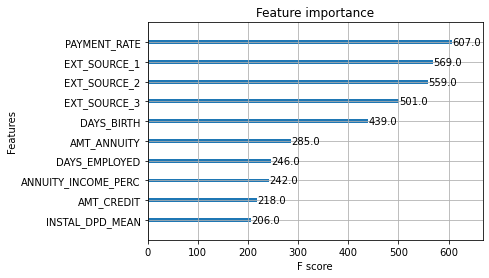

In [18]:
plot_importance(clf, max_num_features=10)
plt.show()

## Fonction coût métier

In [19]:
# On calcule nos probabilités
predictions_proba = clf.predict_proba(df.drop('TARGET', axis = 1))

predictions = clf.predict(df.drop('TARGET', axis = 1))

In [20]:
# On crée une copie de notre jeu de données
df_metier = df.copy()

In [21]:
# On associe nos probabilités et prédictions à de nouvelles colonnes
df_metier['PREDICTIONS_PROBA'] = predictions_proba[:, 0]
df_metier['PREDICTIONS'] = predictions

# On se concentre sur les prêts où on connait la décision
df_metier = df_metier[df_metier['TARGET'].notnull()]

# On crée une colonne pour nos tests
df_metier['PREDICTIONS_TEST'] = df_metier['PREDICTIONS']

In [24]:
def cout_metier(value=0.5):
    df_metier.loc[df_metier['PREDICTIONS_PROBA'] >= value, 'PREDICTIONS_TEST'] = 0
    df_metier.loc[df_metier['PREDICTIONS_PROBA'] < value, 'PREDICTIONS_TEST'] = 1
    
    matrix = confusion_matrix(df_metier['TARGET'], df_metier['PREDICTIONS_TEST'])

    false_neg = matrix[1, 0]
    false_pos = matrix[0, 1]
    total = df_metier.shape[0]
    false_neg_error = round(false_neg / total*100, 2)
    false_pos_error = round(false_pos / total*100, 2)
    total_error = round(false_neg_error + false_pos_error, 2)
    
    print('False negative (ceux qui ne remboursent pas mais on a prédit que oui) :',
          false_neg_error, '%\n')
    print('False positive (ceux qui remboursent mais on a prédit que non) :',
          false_pos_error, '%')
    print('Erreur total =', total_error, '%')

In [25]:
# On teste plusieurs valeurs
for value in [0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6]:
    print('Valeur =', value, '\n')
    cout_metier(value)
    print()
    print('-------------------------------')

Valeur = 0.5 

False negative (ceux qui ne remboursent pas mais on a prédit que oui) : 5.06 %

False positive (ceux qui remboursent mais on a prédit que non) : 3.2 %
Erreur total = 8.26 %

-------------------------------
Valeur = 0.51 

False negative (ceux qui ne remboursent pas mais on a prédit que oui) : 4.94 %

False positive (ceux qui remboursent mais on a prédit que non) : 3.48 %
Erreur total = 8.42 %

-------------------------------
Valeur = 0.52 

False negative (ceux qui ne remboursent pas mais on a prédit que oui) : 4.81 %

False positive (ceux qui remboursent mais on a prédit que non) : 3.79 %
Erreur total = 8.6 %

-------------------------------
Valeur = 0.53 

False negative (ceux qui ne remboursent pas mais on a prédit que oui) : 4.68 %

False positive (ceux qui remboursent mais on a prédit que non) : 4.11 %
Erreur total = 8.79 %

-------------------------------
Valeur = 0.54 

False negative (ceux qui ne remboursent pas mais on a prédit que oui) : 4.55 %

False positive 

On va choisir 0.57 comme seuil.